In [18]:
'''
This code visualizes the effect on (un)reliability of the configuration in which assets operate.
e.g. 1+1 = 1 duty + 1 standby (= 100% redundancy)
e.g. 2+1 = 2 duty + 1 standby (= 50% redundancy)

This code creates an interactive plot, where you can play with:
- weibull parameters (beta= scale parameter, eta= shape parameter), which define the failure behaviour of an asset for one single failure mode
- TTR: time to repair
- % of time the duty asset(s) is (are) in service
- xmax and ymax: for adjusting the x- and y-scale if you want
- sliders to make a plot visible or invisible

The x-axis gives the system time.
If you make 'CDF asset' visible, it will give the CDF (cumulative distribution function = unreliability) as if the asset were in continuous operation.
The other sliders like 'CDF asset 1/2 in 2+1 conf.' etc. give the CDF according to the system time.
Sliders like e.g. 'CDF 2+1-conf. FM 1+0' give the CDF for the failure mode in which the system goes from a 2+1 configuration to a 1+0 configuration. In this case 50% of the capacity is lost.
This means that 1 asset failed. The system became a 2+0 system. During the time to repair (TTR), one of the assets failed as well.

As you will see, there is an important effect of the beta parameter, the TTR and the % of time the duty assets are in service (especially for the 1+1 configuration.)

Have fun!
'''

%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
from scipy.integrate import quad
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.widgets import Slider, Button, RadioButtons

In [19]:
def F(x):
    return 1 - np.exp(-(x/eta)**beta)
def F_inv(y):
    return eta*(-np.log(1-y))**(1/beta)
def f(x):
    return (beta/eta)*(x/eta)**(beta-1)*np.exp(-(x/eta)**beta)
def R(x):
    return np.exp(-(x/eta)**beta)
def h(x):
    return (beta/eta)*(x/eta)**(beta-1)
def H(x):
    return -np.log(R(x))

<IPython.core.display.Javascript object>


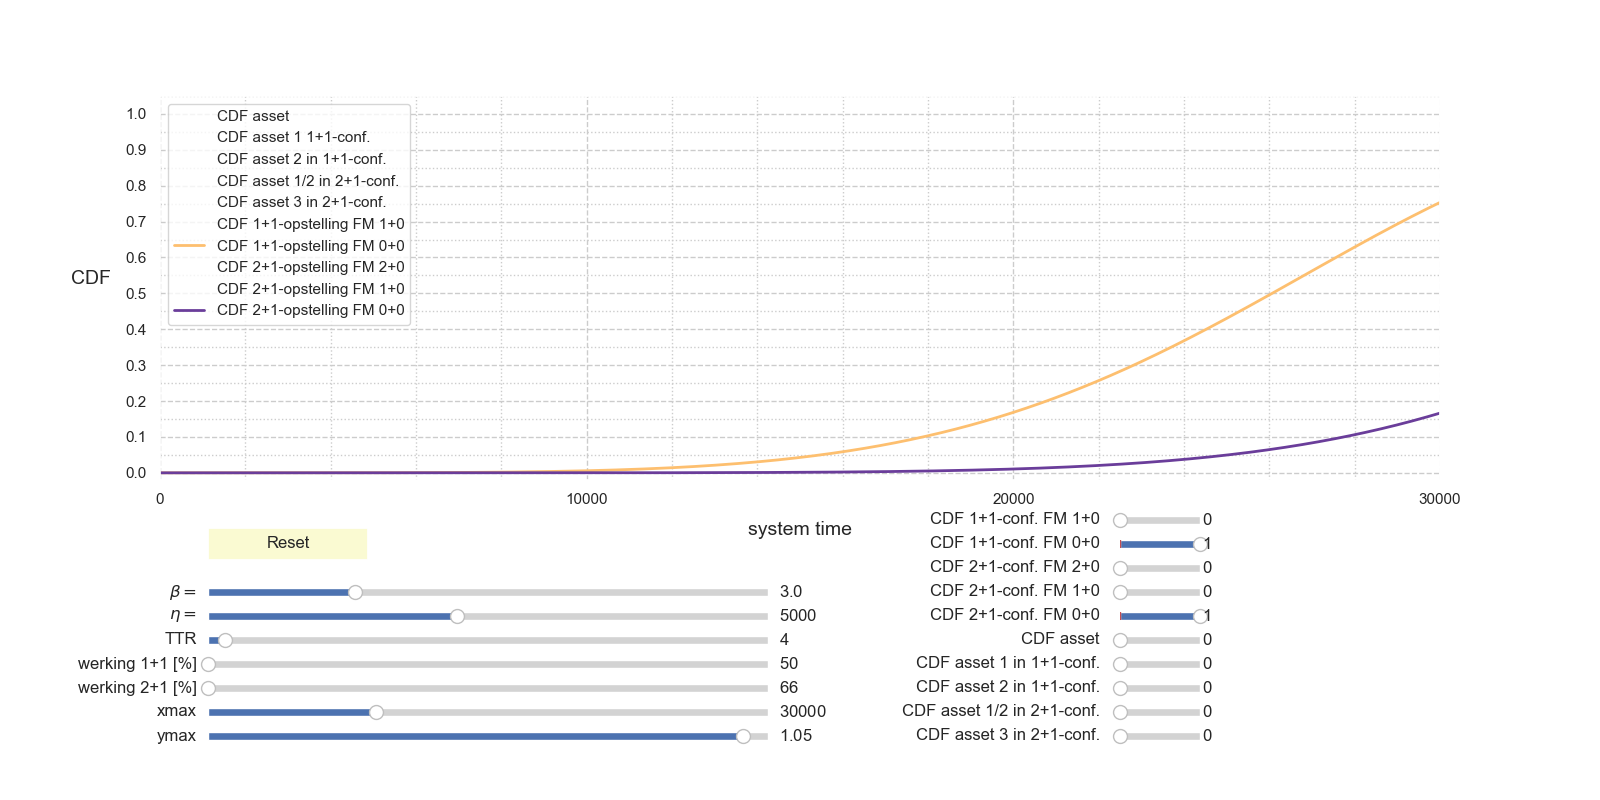

In [36]:
beta_init = 3
eta_init = 5000
ttr_init = 4
pct1p1_init = 50
pct2p1_init = 66
x_init = 30000
y_init = 1.05

fig, ax = plt.subplots(figsize = (16,8))
plt.subplots_adjust(left=0.1, bottom=0.4)
ax.set_ylabel('CDF', rotation=0, fontsize=14, labelpad=25)
ax.set_xlabel('system time', rotation=0, fontsize=14, labelpad=10)
ax.set_xlim(0, 30000)
ax.set_ylim(-0.02, 1.05)

colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']

Ft, = ax.plot([], [], '-', c=colors[0], lw=2, alpha=1, visible=False, label='CDF asset')
F1_1p1,  = ax.plot([], [], '--', c=colors[1], lw=2, alpha=1, visible=False, label='CDF asset 1 1+1-conf.')
F2_1p1,  = ax.plot([], [], '--', c=colors[2], lw=2, alpha=1, visible=False, label='CDF asset 2 in 1+1-conf.')
F1_2p1,  = ax.plot([], [], '--', c=colors[3], lw=2, alpha=1, visible=False, label='CDF asset 1/2 in 2+1-conf.')
F2_2p1,  = ax.plot([], [], '--', c=colors[4], lw=2, alpha=1, visible=False, label='CDF asset 3 in 2+1-conf.')
F10_1p1,  = ax.plot([], [], '-', c=colors[5], lw=2, alpha=1, visible=False, label='CDF 1+1-opstelling FM 1+0')
F00_1p1,  = ax.plot([], [], '-', c=colors[6], lw=2, alpha=1, visible=False, label='CDF 1+1-opstelling FM 0+0')
F20_2p1,  = ax.plot([], [], '-', c=colors[7], lw=2, alpha=1, visible=False, label='CDF 2+1-opstelling FM 2+0')
F10_2p1,  = ax.plot([], [], '-', c=colors[8], lw=2, alpha=1, visible=False, label='CDF 2+1-opstelling FM 1+0')
F00_2p1,  = ax.plot([], [], '-', c=colors[9], lw=2, alpha=1, visible=False, label='CDF 2+1-opstelling FM 0+0')

ax.xaxis.set_major_locator(MultipleLocator(5000))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax_color = 'lightgoldenrodyellow'
ax_beta = plt.axes([0.13, 0.25, 0.35, 0.02], facecolor=ax_color)
ax_eta = plt.axes([0.13, 0.22, 0.35, 0.02], facecolor=ax_color)
ax_ttr = plt.axes([0.13, 0.19, 0.35, 0.02], facecolor=ax_color)
ax_pct1p1 = plt.axes([0.13, 0.16, 0.35, 0.02], facecolor=ax_color)
ax_pct2p1 = plt.axes([0.13, 0.13, 0.35, 0.02], facecolor=ax_color)
ax_x = plt.axes([0.13, 0.10, 0.35, 0.02], facecolor=ax_color)
ax_y = plt.axes([0.13, 0.07, 0.35, 0.02], facecolor=ax_color)
ax_show_F = plt.axes([0.70, 0.19, 0.05, 0.02], facecolor=ax_color)
ax_show_F1_1p1 = plt.axes([0.70, 0.16, 0.05, 0.02], facecolor=ax_color)
ax_show_F2_1p1 = plt.axes([0.70, 0.13, 0.05, 0.02], facecolor=ax_color)
ax_show_F1_2p1 = plt.axes([0.70, 0.10, 0.05, 0.02], facecolor=ax_color)
ax_show_F3_2p1 = plt.axes([0.70, 0.07, 0.05, 0.02], facecolor=ax_color)
ax_show_F10_1p1 = plt.axes([0.70, 0.34, 0.05, 0.02], facecolor=ax_color)
ax_show_F00_1p1 = plt.axes([0.70, 0.31, 0.05, 0.02], facecolor=ax_color)
ax_show_F20_2p1 = plt.axes([0.70, 0.28, 0.05, 0.02], facecolor=ax_color)
ax_show_F10_2p1 = plt.axes([0.70, 0.25, 0.05, 0.02], facecolor=ax_color)
ax_show_F00_2p1 = plt.axes([0.70, 0.22, 0.05, 0.02], facecolor=ax_color)

sl_beta = Slider(ax_beta, r'$\beta=%.2f$', 0.5, 10, valinit=beta_init, valstep=0.1)
sl_eta = Slider(ax_eta, r'$\eta=%.2f$', 1000, 10000, valinit=eta_init, valstep=100)
sl_ttr = Slider(ax_ttr, 'TTR', 1, 100, valinit=ttr_init, valstep=1)
sl_pct1p1 = Slider(ax_pct1p1, 'working time (duty) 1+1 [%]', 50, 100, valinit=pct1p1_init, valstep=1)
sl_pct2p1 = Slider(ax_pct2p1, 'working time (duty) 2+1 [%]', 66, 100, valinit=pct2p1_init, valstep=1)
sl_x = Slider(ax_x, 'xmax', 0, 100000, valinit=x_init, valstep=1000)
sl_y = Slider(ax_y, 'ymax', 0, 1.1, valinit=y_init, valstep=0.05)
sl_show_F = Slider(ax_show_F, 'CDF asset    ', 0, 1, valinit=0, valstep=1)
sl_show_F1_1p1 = Slider(ax_show_F1_1p1, 'CDF asset 1 in 1+1-conf.    ', 0, 1, valinit=0, valstep=1)
sl_show_F2_1p1 = Slider(ax_show_F2_1p1, 'CDF asset 2 in 1+1-conf.    ', 0, 1, valinit=0, valstep=1)
sl_show_F1_2p1 = Slider(ax_show_F1_2p1, 'CDF asset 1/2 in 2+1-conf.    ', 0, 1, valinit=0, valstep=1)
sl_show_F3_2p1 = Slider(ax_show_F3_2p1, 'CDF asset 3 in 2+1-conf.    ', 0, 1, valinit=0, valstep=1)
sl_show_F10_1p1 = Slider(ax_show_F10_1p1, 'CDF 1+1-conf. FM 1+0    ', 0, 1, valinit=0, valstep=1)
sl_show_F00_1p1 = Slider(ax_show_F00_1p1, 'CDF 1+1-conf. FM 0+0    ', 0, 1, valinit=0, valstep=1)
sl_show_F20_2p1 = Slider(ax_show_F20_2p1, 'CDF 2+1-conf. FM 2+0    ', 0, 1, valinit=0, valstep=1)
sl_show_F10_2p1 = Slider(ax_show_F10_2p1, 'CDF 2+1-conf. FM 1+0    ', 0, 1, valinit=0, valstep=1)
sl_show_F00_2p1 = Slider(ax_show_F00_2p1, 'CDF 2+1-conf. FM 0+0    ', 0, 1, valinit=0, valstep=1)

def update(val):
    def F(x):
        return 1 - np.exp(-(x/sl_eta.val)**sl_beta.val)
    def F_inv(y):
        return sl_eta.val*(-np.log(1-y))**(1/sl_beta.val)
    def f(x):
        return (sl_beta.val/sl_eta.val)*(x/sl_eta.val)**(sl_beta.val-1)*np.exp(-(x/sl_eta.val)**sl_beta.val)
    def R(x):
        return np.exp(-(x/sl_eta.val)**sl_beta.val)
    def h(x):
        return (sl_beta.val/sl_eta.val)*(x/sl_eta.val)**(sl_beta.val-1)
    def H(x):
        return -np.log(R(x))
    
    ttr = sl_ttr.val
    pct1p1 = sl_pct1p1.val
    pct2p1 = sl_pct2p1.val
    ax.set_xlim(0,sl_x.val)
    ax.set_ylim(-0.02,sl_y.val)
    t = np.linspace(0,sl_x.val,1000)
    
    if sl_show_F.val==1:
        Ft.set_data(t, F(t))
        Ft.set_visible(True)
    else:
        Ft.set_visible(False)
    
    if sl_show_F1_1p1.val==1:
        F1_1p1.set_data(t*100/sl_pct1p1.val, F(t))
        F1_1p1.set_visible(True)
    else:
        F1_1p1.set_visible(False)
        
    if sl_show_F2_1p1.val==1:
        F2_1p1.set_data(t*100/(100-sl_pct1p1.val), F(t))
        F2_1p1.set_visible(True)
    else:
        F2_1p1.set_visible(False)
        
    if sl_show_F10_1p1.val==1:
        td = sl_pct1p1.val/100
        tr = 1-td
        def Ch1011(x):
            return h(x*td) + h(x*tr)
        def I1011(x):
            Integraal, err= quad(Ch1011, 0, x)
            return Integraal
        hct1011 = Ch1011(t)
        Hct1011 = t.copy()
        i=0
        while i<len(Hct1011):
            Hct1011[i]=I1011(t[i])
            i+=1
        F10_1p1.set_data(t,1-np.exp(-Hct1011))
        F10_1p1.set_visible(True)
    else:
        F10_1p1.set_visible(False)
        
    if sl_show_F00_1p1.val==1:
        dt = sl_ttr.val
        td = sl_pct1p1.val/100
        tr = 1-td
        def Ch0011(x):
            return h(x*td)*(H(x*tr+dt)-H(x*tr)) + h(x*tr)*(H(x*td+dt)-H(x*td))
        def I0011(x):
            Integraal, err= quad(Ch0011, 0, x)
            return Integraal
        hct0011 = Ch0011(t)
        Hct0011 = t.copy()
        i=0
        while i<len(Hct0011):
            Hct0011[i]=I0011(t[i])
            i+=1
        F00_1p1.set_data(t,1-np.exp(-Hct0011))
        F00_1p1.set_visible(True)
    else:
        F00_1p1.set_visible(False)
    
    if sl_show_F1_2p1.val==1:
        F1_2p1.set_data(t*100/sl_pct2p1.val, F(t))
        F1_2p1.set_visible(True)
    else:
        F1_2p1.set_visible(False)
        
    if sl_show_F3_2p1.val==1:
        F2_2p1.set_data(t*100/(200-2*sl_pct2p1.val), F(t))
        F2_2p1.set_visible(True)
    else:
        F2_2p1.set_visible(False)
        
    if sl_show_F20_2p1.val==1:
        r1 = sl_pct2p1.val/100; r2 = r1; r3 = 2*(1-r1)
        def Ch2021(x):
            x1 = x*r1; x2 = x*r2; x3 = x*r3
            h1 = h(x1); h2=h(x2); h3=h(x3)
            return h1 + h2 + h3
        def I2021(x):
            Integraal1, err= quad(Ch2021, 0, x)
            return Integraal1
        hct2021 = Ch2021(t)
        Hct2021 = t.copy()
        i=0
        while i<len(Hct2021):
            Hct2021[i]=I2021(t[i])
            i+=1
        F20_2p1.set_data(t,1-np.exp(-Hct2021))
        F20_2p1.set_visible(True)
    else:
        F20_2p1.set_visible(False)
    
    if sl_show_F10_2p1.val==1:
        dt = sl_ttr.val
        r1 = sl_pct2p1.val/100; r2 = r1; r3 = 2*(1-r1)
        def Ch1021(x):
            x1 = x*r1; x2 = x*r2; x3 = x*r3
            h1 = h(x1); h2=h(x2); h3=h(x3)
            H1 = H(x1+dt)-H(x1); H2 = H(x2+dt)-H(x2); H3 = H(x3+dt)-H(x3)
            return h1*(H2+H3) + h2*(H1+H3) + h3*(H1+H2)
        def I1021(x):
            Integraal1, err= quad(Ch1021, 0, x)
            return Integraal1
        hct1021 = Ch1021(t)
        Hct1021 = t.copy()
        i=0
        while i<len(Hct1021):
            Hct1021[i]=I1021(t[i])
            i+=1
        F10_2p1.set_data(t,1-np.exp(-Hct1021))
        F10_2p1.set_visible(True)
    else:
        F10_2p1.set_visible(False)
        
    if sl_show_F00_2p1.val==1:
        dt = sl_ttr.val
        r1 = sl_pct2p1.val/100; r2 = r1; r3 = 2*(1-r1)
        def Ch0021(x):
            x1 = x*r1; x2 = x*r2; x3 = x*r3
            h1 = h(x1); h2=h(x2); h3=h(x3)
            H1 = H(x1+dt)-H(x1); H2 = H(x2+dt)-H(x2); H3 = H(x3+dt)-H(x3)
            return h1*(H2*H3) + h2*(H1*H3) + h3*(H1*H2)
        def I0021(x):
            Integraal1, err= quad(Ch0021, 0, x)
            return Integraal1
        hct0021 = Ch0021(t)
        Hct0021 = t.copy()
        i=0
        while i<len(Hct0021):
            Hct0021[i]=I0021(t[i])
            i+=1
        F00_2p1.set_data(t,1-np.exp(-Hct0021))
        F00_2p1.set_visible(True)
    else:
        F00_2p1.set_visible(False)
    
    if sl_x.val<=100:
        mark=20
    elif sl_x.val<=200:
        mark=50
    elif sl_x.val<=500:
        mark=100
    elif sl_x.val<=1000:
        mark=200
    elif sl_x.val<=2000:
        mark=500
    elif sl_x.val<=5000:
        mark=1000
    elif sl_x.val<=10000:
        mark=2000
    elif sl_x.val<=20000:
        mark=5000
    elif sl_x.val<=50000:
        mark=10000
    ax.xaxis.set_major_locator(MultipleLocator(mark))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.legend(loc=2)

sl_beta.on_changed(update)
sl_eta.on_changed(update)
sl_ttr.on_changed(update)
sl_pct1p1.on_changed(update)
sl_pct2p1.on_changed(update)
sl_x.on_changed(update)
sl_y.on_changed(update)
sl_show_F.on_changed(update)
sl_show_F1_1p1.on_changed(update)
sl_show_F2_1p1.on_changed(update)
sl_show_F1_2p1.on_changed(update)
sl_show_F3_2p1.on_changed(update)
sl_show_F10_1p1.on_changed(update)
sl_show_F00_1p1.on_changed(update)
sl_show_F20_2p1.on_changed(update)
sl_show_F10_2p1.on_changed(update)
sl_show_F00_2p1.on_changed(update)


resetax = plt.axes([0.13, 0.30, 0.1, 0.04])
button = Button(resetax, 'Reset', color=ax_color, hovercolor='0.975')

def reset(event):
    sl_beta.reset()
    sl_eta.reset()
    sl_ttr.reset()
    sl_pct1p1.reset()
    sl_pct2p1.reset()
    sl_x.reset()
    sl_y.reset()
button.on_clicked(reset)

plt.show()